In [1]:
import os
import numpy as np
import pandas as pd
import pickle
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
model_path = './mtl_phase2_results/phase2_best.h5'
model = load_model(model_path)
print("✅ Model loaded:", model_path)


✅ Model loaded: ./mtl_phase2_results/phase2_best.h5


In [3]:
with open('./encoders/label_encoder_taskA.pkl', 'rb') as f:
    le_classA = pickle.load(f)

with open('./encoders/label_encoder_taskB.pkl', 'rb') as f:
    le_classB = pickle.load(f)

num_classes_A = len(le_classA.classes_)
num_classes_B = len(le_classB.classes_)


In [4]:
csv_path = '/media/tohn/HDD/VISION_dataset/USAI/Data_CCA_6569.csv'
df = pd.read_csv(csv_path)

test_df = df[
    (df['Spilt'] == 'Test') &
    (df['Path Crop'] != 'None') &
    (df['Path Crop'] != 'Nan')
].reset_index(drop=True)

print("Test samples:", len(test_df))

Test samples: 1312


In [5]:
test_df['TaskA_encoded'] = le_classA.transform(test_df['Sub_class_New'])
test_df['TaskB_encoded'] = le_classB.transform(test_df['Sub_Position_Label'])


In [6]:
IMG_SIZE = 456
BATCH_SIZE = 4

def load_and_preprocess_image(path, label_A, label_B):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = tf.cast(img, tf.float32)
    img = preprocess_input(img)
    return img, (label_A, label_B)

def create_test_dataset(df):
    paths = df['Path Crop'].values
    labels_A = to_categorical(df['TaskA_encoded'].values, num_classes_A)
    labels_B = to_categorical(df['TaskB_encoded'].values, num_classes_B)

    ds = tf.data.Dataset.from_tensor_slices((paths, labels_A, labels_B))
    ds = ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

test_dataset = create_test_dataset(test_df)


In [7]:
print("\n📊 Evaluating model on Test set...")
results = model.evaluate(test_dataset, verbose=1)

for name, value in zip(model.metrics_names, results):
    print(f"{name:30s}: {value:.4f}")



📊 Evaluating model on Test set...
328/328 [==============================] - 24s 61ms/step - loss: 1.3911 - task_subclass_loss: 0.4851 - task_position_loss: 0.9060 - task_subclass_accuracy: 0.8483 - task_position_accuracy: 0.7294
loss                          : 1.3911
task_subclass_loss            : 0.4851
task_position_loss            : 0.9060
task_subclass_accuracy        : 0.8483
task_position_accuracy        : 0.7294


In [8]:
print("\n🔮 Predicting...")
pred_A, pred_B = model.predict(test_dataset, verbose=1)

y_true_A = test_df['TaskA_encoded'].values
y_true_B = test_df['TaskB_encoded'].values

y_pred_A = np.argmax(pred_A, axis=1)
y_pred_B = np.argmax(pred_B, axis=1)



🔮 Predicting...
328/328 [==============================] - 17s 45ms/step


In [9]:
print("\n📘 Task A - Classification Report")
print(classification_report(
    y_true_A,
    y_pred_A,
    target_names=le_classA.classes_
))



📘 Task A - Classification Report
              precision    recall  f1-score   support

        AB01       0.68      0.80      0.73        74
        AB02       0.65      0.54      0.59        59
        AB03       0.62      0.53      0.57        19
        AB04       0.43      0.58      0.49        38
        AB05       0.58      0.38      0.46        29
        AB06       0.60      0.43      0.50        21
        AB07       0.52      0.52      0.52        21
       AB081       0.28      0.25      0.26        32
       AB082       0.40      0.29      0.33        28
       AB083       0.00      0.00      0.00        11
        AB09       0.50      0.92      0.65        26
        AB10       0.00      0.00      0.00        10
        AB11       0.85      0.91      0.88        55
        AB12       0.82      0.84      0.83        32
      Normal       0.97      0.98      0.98       857

    accuracy                           0.85      1312
   macro avg       0.53      0.53      0.52   

/home/yupaporn/miniconda3/envs/bitnet-unlearn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [10]:
print("\n📗 Task B - Classification Report")
print(classification_report(
    y_true_B,
    y_pred_B,
    target_names=le_classB.classes_
))



📗 Task B - Classification Report
              precision    recall  f1-score   support

          P1       0.70      0.68      0.69       140
         P11       0.85      0.81      0.83        95
         P12       0.74      0.91      0.82       102
         P14       0.79      0.92      0.85       119
         P15       0.83      0.31      0.45        32
         P16       0.90      0.89      0.89        71
          P2       0.80      0.80      0.80       118
          P3       0.55      0.52      0.54       136
          P4       0.67      0.59      0.63       101
          P5       0.50      0.51      0.51       105
          P6       0.78      0.86      0.82       125
          P7       0.72      0.76      0.74        75
          P8       1.00      0.05      0.09        22
          P9       0.85      0.90      0.88        71

    accuracy                           0.73      1312
   macro avg       0.76      0.68      0.68      1312
weighted avg       0.73      0.73      0.72   

In [11]:
def plot_confusion_matrix(y_true, y_pred, class_names, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.tight_layout()
    plt.show()


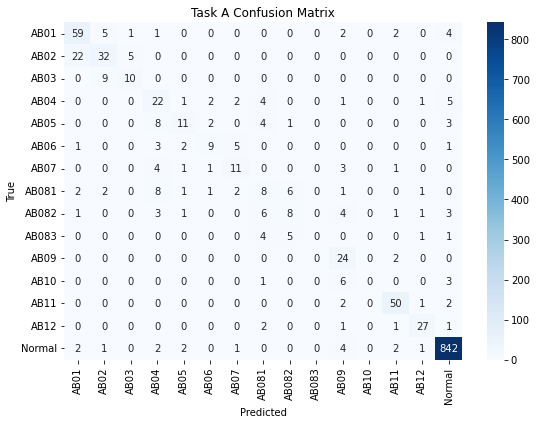

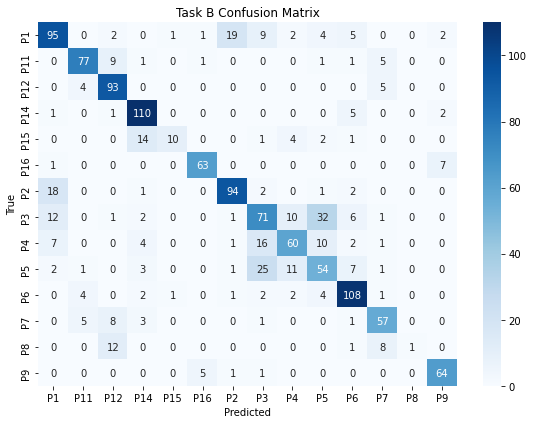

In [12]:
plot_confusion_matrix(
    y_true_A, y_pred_A,
    le_classA.classes_,
    'Task A Confusion Matrix'
)

plot_confusion_matrix(
    y_true_B, y_pred_B,
    le_classB.classes_,
    'Task B Confusion Matrix'
)


In [13]:
joint_correct = np.logical_and(
    y_true_A == y_pred_A,
    y_true_B == y_pred_B
)

joint_acc = joint_correct.mean()
print(f"\n🎯 Joint Accuracy (A ∧ B): {joint_acc:.4f} ({joint_acc*100:.2f}%)")



🎯 Joint Accuracy (A ∧ B): 0.6524 (65.24%)
